In [1]:
import tensorflow as tf
import numpy as np
import scipy.io
from pyDOE import lhs
import math

D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1ty

In [2]:
RandomSeed = 9
np.random.seed(RandomSeed)
tf.set_random_seed(RandomSeed)

In [3]:
class PtPINNsss:
    # Initialize the class
    def __init__(self, x, t, u, lb, ub, lbp,ubp, layers,weights_values,biases_values):
        
        X = np.concatenate([x, t], 1)

        self.X = X
        
        self.x = X[:,0:1]
        self.t = X[:,1:2]
        
        self.u = u      
        self.lb = lb
        self.ub = ub
        self.hsadasjd=0
        self.ubp = ubp
        self.lbp = lbp        
        # Initialize NNs
        self.layers = layers
        self.hh=[]
        self.hh1=[]      
        
        self.weights, self.biases = self.initialize_NN(layers)
        
        # Calculate the values and convert them to float32
        value_float64 = 3.0/4
        self.b = tf.Variable(value_float64, dtype=tf.float64)
        
        value_float64=  1.0/(math.cosh(5*0.5)-1)       
        
        self.a = tf.constant(value_float64, dtype=tf.float64)     
        
        
        
        self.weights_values = weights_values        
        self.biases_values = biases_values    

        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))    

        self.x_f_tf = tf.placeholder(tf.float64, shape=[None, self.x.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float64, shape=[None, self.t.shape[1]])
        
        self.x_lb_tf = tf.placeholder(tf.float64, shape=[None, self.x.shape[1]])
        self.t_b_tf = tf.placeholder(tf.float64, shape=[None, self.t.shape[1]])
        self.x_ub_tf = tf.placeholder(tf.float64, shape=[None, self.x.shape[1]])
        
        self.x_tf = tf.placeholder(tf.float64, shape=[None, self.x.shape[1]])
        self.t_tf = tf.placeholder(tf.float64, shape=[None, self.t.shape[1]])
        
        self.u_tf = tf.placeholder(tf.float64, shape=[None, self.u.shape[1]])

        self.u_pred, _ ,self.uuuuuu = self.net_AC(self.x_tf, self.t_tf)
        self.u_lb_pred, self.ux_lb_pred,_ = self.net_AC(self.x_lb_tf, self.t_b_tf)
        self.u_ub_pred, self.ux_ub_pred,_ = self.net_AC(self.x_ub_tf, self.t_b_tf)

        self.f_pred = self.net_f(self.x_f_tf, self.t_f_tf)
        

        
        self.lossS = tf.reduce_mean(tf.square(self.u_tf - self.u_pred))                                              
        self.lossB = tf.reduce_mean(tf.square(self.u_lb_pred - self.u_ub_pred)) + tf.reduce_mean(tf.square(self.ux_lb_pred - self.ux_ub_pred))
        self.lossfu =  tf.reduce_mean(tf.square(self.f_pred))    
        

        self.optimizer_Adam = tf.train.AdamOptimizer()

        self.loss  =  64 * self.lossS + self.lossB + self.lossfu
        
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)      

        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
    
        init = tf.global_variables_initializer()
        self.sess.run(init)
        self.save = tf.train.Saver(max_to_keep=1)
              
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = tf.Variable(tf.zeros([layers[l], layers[l+1]], dtype=tf.float64), dtype=tf.float64)
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float64), dtype=tf.float64)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    
    
    def initialize_NN2(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float64), dtype=tf.float64)
            weights.append(W)
            biases.append(b)        
        return weights, biases      
    
    
    
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=tf.float64))
    
    def custom_function(self,t):
        
        ab= self.b     
        
        condition2 = tf.less_equal(t, 0.5)
        condition3 = tf.less_equal(t, ab)
        condition4 = tf.less_equal(ab, 1)
        
        BB=2*(t-0.5)
        
        
        B=1/(ab-0.5)*(t-0.5)
        
        return tf.where(condition2, tf.zeros_like(t), tf.where(condition4,tf.where(condition3, -2*B**3+3*B**2,tf.zeros_like(t)+1),-2*BB**3+3*BB**2))
    
 

    def input_encoding(self, t, x):    
        H=tf.concat([t,1+0*tf.cos(math.pi*x)],1)
        H=tf.concat([H,tf.cos(math.pi*x)],1)
        H=tf.concat([H,tf.sin(math.pi*x)],1) 
        H=tf.concat([H,tf.cos(2*math.pi*x)],1)
        H=tf.concat([H,tf.sin(2*math.pi*x)],1)         
        H=tf.concat([H,tf.cos(3*math.pi*x)],1)
        H=tf.concat([H,tf.sin(3*math.pi*x)],1)         
        H=tf.concat([H,tf.cos(4*math.pi*x)],1)
        H=tf.concat([H,tf.sin(4*math.pi*x)],1)         
        H=tf.concat([H,tf.cos(5*math.pi*x)],1)
        H=tf.concat([H,tf.sin(5*math.pi*x)],1)         
        H=tf.concat([H,tf.cos(6*math.pi*x)],1)
        H=tf.concat([H,tf.sin(6*math.pi*x)],1)         
        H=tf.concat([H,tf.cos(7*math.pi*x)],1)
        H=tf.concat([H,tf.sin(7*math.pi*x)],1)         
        H=tf.concat([H,tf.cos(8*math.pi*x)],1)
        H=tf.concat([H,tf.sin(8*math.pi*x)],1)         
        H=tf.concat([H,tf.cos(9*math.pi*x)],1)
        H=tf.concat([H,tf.sin(9*math.pi*x)],1)         
        H=tf.concat([H,tf.cos(10*math.pi*x)],1)
        H=tf.concat([H,tf.sin(10*math.pi*x)],1)           
        
        return H


    def neural_net(self, x,t, weights, biases,weights_values,biases_values):
        X = tf.concat([x,t],1)
        tt=2*t
        num_layers = len(weights) + 1
        H = self.input_encoding(tt, x)
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            W1 = weights_values[l]
            b1 = biases_values[l]   
            H0 = tf.add(tf.matmul(H, W), b)
            H1 = tf.add(tf.matmul(H, W1), b1)
            
            B = self.custom_function(t)   
            H0 = H0*B              
            
            H  = tf.add(H0,H1)
            H =  tf.tanh(H)
        
        W = weights[-1]
        b = biases[-1]
        W1 = weights_values[-1]
        b1 = biases_values[-1]  
        
        H0 = tf.add(tf.matmul(H, W), b)
        
        B = self.custom_function(t)   
        H0 = H0*B            
        
        H1 = tf.add(tf.matmul(H, W1), b1) 
        H  = tf.add(H0,H1)      
        Y = H
        return Y
    
    def net_AC(self, x, t):
        u = self.neural_net(x,t, self.weights, self.biases,self.weights_values, self.biases_values)
        u_x = tf.gradients(u, x)[0]
        u_t = tf.gradients(u, t)[0]

        return u, u_x, u_t
          
    

    def net_f(self, x, t):
        u, u_x, u_t = self.net_AC(x, t)
        
        u_xx = tf.gradients(u_x, x)[0]
        
        f_u = u_t - 0.0001*u_xx+5*u**3-5*u
        
        return f_u
    
    def callback(self, loss, a,b,lossfu, lossS, lossB):
        sss=self.hsadasjd
        if sss%1000==0:
            print('Loss: %.6e, Lossfu: %.3e, LossS: %.3e, LossB: %.3e ' % (loss, lossfu, lossS, lossB))
        sss=sss+1
        self.hsadasjd=sss 
        self.hh.append(a)      
        self.hh1.append(b)        
    def train(self, nIter, Nf, Nn, Nb):

        X_train = self.lbp + (self.ubp-self.lbp)*lhs(2, Nf)
        self.xtrain_f = X_train[:,0:1]
        self.ttrain_f = X_train[:,1:2] 
        
        X_lb_train = self.lbp + [0,self.ubp[1]-self.lbp[1]]*lhs(2, Nb)
        self.xtrain_lb = X_lb_train[:,0:1]
        self.ttrain_b = X_lb_train[:,1:2]
        
        X_ub_train = [self.ubp[0],self.lbp[1]] + [0,self.ubp[1]-self.lbp[1]]*lhs(2, Nb)
        self.xtrain_ub = X_ub_train[:,0:1]
        
        tf_dict = {self.x_tf: self.x, self.t_tf: self.t, self.u_tf: self.u,
                   self.x_lb_tf: self.xtrain_lb, self.t_b_tf: self.ttrain_b, 
                   self.x_ub_tf: self.xtrain_ub, 
                   self.x_f_tf: self.xtrain_f, self.t_f_tf: self.ttrain_f}

        for it in range(nIter):
            loss_value = self.sess.run(self.loss, tf_dict)
            lossfu = self.sess.run(self.lossfu, tf_dict)
            lossS = self.sess.run(self.lossS, tf_dict)
            lossB = self.sess.run(self.lossB, tf_dict)
            self.sess.run(self.train_op_Adam, tf_dict)
                
            ab= self.sess.run(self.a)
            self.hh.append(ab)       
            abc= self.sess.run(self.b)
            self.hh1.append(abc)    

            print(abc)                    
            if it % 1000 == 0:
                print('It: %d, Loss: %.6e, Lossfu: %.3e, LossS: %.3e, LossB: %.3e' % (it, loss_value, lossfu, lossS, lossB))
                        
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, method = 'L-BFGS-B', options = {'maxiter': 50000,'maxfun': 50000,'maxcor': 50,'maxls': 50,'ftol' : 1.0 * np.finfo(float).eps})                                                                                                         
        self.optimizer.minimize(self.sess, feed_dict = tf_dict, fetches = [self.loss,self.a,self.b,  self.lossfu, self.lossS, self.lossB], loss_callback = self.callback)        
                                    
    
    def predict(self, x, t):
        
        tf_dict = {self.x_tf: x, self.t_tf: t}
        u_star = self.sess.run(self.u_pred, tf_dict)
        u_starssss = self.sess.run(self.uuuuuu, tf_dict)        
        return u_star,u_starssss

    def saver(self, string):
        self.save.save(self.sess, 'ckpt/'+string)
        
        
    def sssss(self):
        return self.hh,  self.hh1           
        
        
    def restore(self):
        model_file = tf.train.latest_checkpoint('ckpt/')
        self.save.restore(self.sess, model_file)

In [4]:
import pickle

In [5]:
with open('bcweights.pkl', 'rb') as f:
    weights_values = pickle.load(f)

In [6]:
with open('bcweights1.pkl', 'rb') as f:
    biases_values = pickle.load(f)

In [7]:
if __name__ == "__main__": 
           
    
    # Doman bounds
    lb = np.array([-1.0, 0])
    ub = np.array([1.0, 0.5])

    # Pre-training interval
    lbp = np.array([-1.0, 0])    
    ubp = np.array([1.0,1.0])


    
    layers = [22, 100, 100, 100, 100, 1]
    
    data = scipy.io.loadmat('AC.mat')
    
    t = data['tt'].flatten()[:,None]
    x = data['x'].flatten()[:,None]
    Exact = data['uu']
    
    X, T = np.meshgrid(x,t)
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_star = Exact.T.flatten()[:,None]

    def IC(x):
        u = x**2*np.cos(np.pi*x)
        return u

    N0 = 1200
    x=np.linspace(-1,1,N0).flatten()[:,None]  
    X0 =x
    T0 = np.full((N0,1), lb[1])
    U0 = IC(X0)
      
    model2 = PtPINNsss(X0, T0, U0, lb, ub,lbp, ubp, layers,weights_values,biases_values)                        
    model2.train(5000, 20000, 1200, 1200)  
    model2.saver('testmodel.ckpt')
    


    u_pred ,_= model2.predict(X_star[:,0:1],X_star[:,1:2])

    erroru = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    erroru1 = np.linalg.norm(u_star-u_pred,1)/len(X_star)
    erroruinf = np.linalg.norm(u_star-u_pred,np.inf)
    
    print('randorm seed: %d' % (RandomSeed))
    print('Training error in pre-training interval:(%.2f,%.2f)' % (lb[1], ubp[1]) ) 
    print('Error2 u: %e' % (erroru))
    print('Error1 u: %e' % (erroru1))
    print('Errorf u: %e' % (erroruinf))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
0.75
It: 0, Loss: 3.474355e-01, Lossfu: 3.474e-01, LossS: 2.007e-08, LossB: 1.697e-28
0.7507441342556203
0.7515433517405187
0.7524165481512921
0.7533341297441846
0.7542806867981613
0.755246557979642
0.7562233669580497
0.7572023714068343
0.7581727522481079
0.7591213277126505
0.7600380516299656
0.7609256749975587
0.7617943714988156
0.7626444480181713
0.76346429959324
0.764241669046399
0.764971278080965
0.7656531353653614
0.7662908035033977
0.7668945542233209
0.7674760598006526
0.768039273406028
0.7685816444653163
0.7691010881659112
0.7695982353922827
0.7700730091097698
0.7705224007243067
0.7709425021529407
0.7713324501665274
0.7716947927088921
0.7720315304786005
0.7723425952307856
0.7726289352430837
0.7728938736185526
0.7731401766870176
0.773369348821569
0.7735831446607895
0.7737836852344494
0.773972685682459
0.7741510349196679
0.774318869373763
0.7744763286025913
0.774

0.7868028265332703
0.7868388143631823
0.7868748339849315
0.7869108849395074
0.7869469602000458
0.786983059643871
0.7870191850957997
0.7870553364406354
0.787091513473226
0.7871277097767565
0.7871639257554485
0.7872001695137535
0.7872364405144329
0.7872727381568219
0.7873090621965482
0.7873454121395489
0.7873817681608016
0.7874181317878614
0.787454504689302
0.7874908880388127
0.7875272836459081
0.7875636899087635
0.7876001077409394
0.7876365462718493
0.7876730086930049
0.787709494567993
0.7877459856486526
0.7877824833946593
0.7878189890577699
0.7878555119229328
0.7878920520931021
0.7879286103326781
0.7879651865965822
0.788001775200846
0.7880383766344232
0.7880749956958644
0.7881116369635854
0.7881482998714863
0.788184983896419
0.7882216912594292
0.788258418722847
0.788295167175178
0.7883319360570172
0.7883687334747003
0.7884055581856958
0.788442412159304
0.7884792934327041
0.7885162008154838
0.7885531689957616
0.788590193399085
0.7886272711290228
0.7886644019996337
0.7887015820975224
0.7

0.804094922828029
0.8041351919965036
0.804175431203704
0.8042156389019499
0.8042558186871922
0.8042959786246207
0.804336122770059
0.8043762573267338
0.8044163793087398
0.8044564862300582
0.8044965750993234
0.8045366431156293
0.80457669119216
0.8046167265623283
0.8046567459964092
0.8046967464703899
0.8047367270299568
0.8047766851577879
0.8048166361792747
0.8048565761830366
0.8048965015390169
0.8049364105668374
0.8049763002755824
0.805016170319105
0.8050560180345636
0.8050958408469336
0.8051356624186089
0.8051754779366156
0.8052152832556755
0.8052550761724178
0.8052948531761263
0.8053346118643446
0.8053743493061116
0.8054140662266873
0.8054537615139632
0.8054934325404035
0.8055330789853887
0.8055726984945262
0.8056122862246465
0.80565186686655
0.8056914364330592
0.8057309921754008
0.8057705306604795
0.8058100707274685
0.8058496340924615
0.8058892134737349
0.8059288035680319
0.8059683983253124
0.8060080496724645
0.8060477471836855
0.8060874820155883
0.8061272451490928
0.8061670289307084
0

0.8207843335208198
0.8208225447720379
0.820860777520864
0.8208990252099757
0.8209372813547874
0.8209755400885851
0.8210137961950436
0.8210520473486406
0.8210902908920238
0.8211285231239354
0.8211667402879397
0.8212049737862285
0.8212432171264071
0.8212814643211851
0.8213197112434302
0.821357952679596
0.8213961847342802
0.8214344029019295
0.82147260418246
0.8215107849473268
0.8215489435123305
0.8215870805621942
0.821625195843506
0.8216632834429025
0.8217013460622589
0.8217393756917891
0.8217773793823112
0.8218153356394163
0.82185326156604
0.8218911322754391
0.8219289829758029
0.8219667657307035
0.8220045601529293
0.8220423196496036
0.8220801898980546
0.8221180095860381
0.8221561269078498
0.8221942927568548
0.8222334088176779
0.8222732891737963
0.8223163390908572
0.8223630684050794
0.8224182670157951
0.8224809280655104
0.8225516882065018
0.8226228461319681
0.82269119066536
0.8227563249530256
0.8228204526317564
0.8228869382096243
0.822954154103321
0.8230218769545271
0.8230871815580455
0.8

0.8369612679323308
0.8369904989867336
0.8370197285338568
0.8370489571273219
0.8370781761351219
0.8371073875243569
0.8371365834594265
0.8371657662716424
0.8371949319044637
0.8372240829759207
0.8372532302800991
0.8372823812046711
0.8373115261082184
0.8373406683885499
0.837369795039864
0.8373989183675069
0.8374280269833854
0.8374571342676834
0.8374862265532516
0.837515317843619
0.8375443897418144
0.8375734587203089
0.8376025012346816
0.8376315408115779
0.8376605471313165
0.837689555045524
0.8377185214734147
0.8377475004199539
0.8377764311570041
0.8378053929923842
0.8378342973181127
0.8378632691541422
0.837892179307945
0.8379212252123411
0.8379502227010014
0.8379795181208599
0.8380088608015143
0.8380388597058388
0.8380692188902592
0.8381010374590258
0.8381340086781975
0.8381701107524685
0.8382090153922745
0.8382532434266877
0.8383017417795297
0.8383556402537847
0.8384119944988426
0.8384694783196474
0.8385253597971541
0.838578888281824
0.8386299655247021
0.8386794159531561
0.838728870485295

0.8517836369157205
0.8518091950849808
0.8518346867426062
0.851860234717442
0.8518857008033692
0.8519112475802929
0.8519366904910933
0.8519623099220192
0.8519878466257333
0.8520136229687434
0.8520392799076674
0.8520652997673065
0.8520911730970256
0.8521176488101738
0.8521440228638175
0.852171481319326
0.852199079517119
0.8522286783815833
0.8522591582718849
0.8522931065436266
0.8523291514708042
0.8523697727266225
0.8524129722861145
0.8524595511166024
0.8525071895188584
0.852555506289815
0.8526042621291587
0.8526532492678499
0.8527051099974342
0.8527598140693825
0.8528216992315708
0.8528896534702304
0.8529667380321995
0.853048436048711
0.8531346333100814
0.8532192763242683
0.8533016495318078
0.8533796141486084
0.8534533529514577
0.8535245546103838
0.8535924334768908
0.8536584570185654
0.8537207564774769
0.8537799827933208
0.8538357874801368
0.8538885940660516
0.8539395796826615
0.8539883433883061
0.8540357477345352
0.8540810857788301
0.8541245653572035
0.8541667217861286
0.854207168236822

0.8677238196190481
0.8677912971583224
0.8678574758115539
0.8679220876364702
0.8679847030301152
0.8680441872971731
0.868100159341913
0.8681523114430411
0.8682014239734129
0.8682479162729972
0.8682929577307318
0.8683365773795618
0.8683793096814414
0.8684204940894237
0.8684602123272428
0.8684979282938607
0.8685338901094851
0.8685682405045918
0.8686013033735422
0.8686335136381755
0.8686648943628459
0.8686956923124591
0.8687255916721993
0.8687547302619123
0.8687828640485535
0.8688101532477949
0.8688366506054958
0.8688625130054306
0.8688879274765203
0.8689129239496968
0.8689376011819819
0.8689619076996669
0.868985818977299
0.8690093618271172
0.8690324343707128
0.8690552415633052
0.8690776211539427
0.8690999220803364
0.8691218800247974
0.869143900006738
0.8691656341700815
0.869187492401771
0.8692090753717326
0.8692308215543798
0.8692523374869227
0.8692741023573592
0.8692957380528549
0.869317805664776
0.8693398941181262
0.8693627158406495
0.8693857742311479
0.869409983572838
0.869434714058089


0.8835184401424979
It: 3000, Loss: 1.583807e-04, Lossfu: 1.571e-04, LossS: 2.007e-08, LossB: 1.762e-28
0.883540449761981
0.883562117416321
0.8835834309134064
0.8836045388998753
0.8836252638790705
0.8836456311875686
0.8836655884951684
0.8836851681837326
0.8837044992204907
0.8837235603866328
0.8837424598764069
0.8837611104265382
0.8837795469453151
0.8837977574019685
0.8838157624070194
0.8838336399062641
0.8838513624447948
0.8838690020898472
0.8838864912531218
0.883903863483993
0.8839210977996567
0.8839382080746822
0.883955242766015
0.8839721799625138
0.8839890785779508
0.8840058934670789
0.8840226684786454
0.8840393767192744
0.8840560372255533
0.8840726603514362
0.8840892367601052
0.8841058036471293
0.8841223354020219
0.8841388786441714
0.8841554042061315
0.884171939478922
0.8841884700312094
0.8842050002726953
0.8842215400087748
0.8842380763510708
0.8842546344241164
0.884271211755883
0.8842878259918414
0.8843044484540952
0.884321085299655
0.8843377230192343
0.8843543621837714
0.884371006

0.898481169843641
0.8985017237009604
0.8985213414392936
0.8985402163786308
0.8985583532874764
0.8985758359810061
0.8985928822717941
0.8986094505023492
0.8986258137771379
0.8986419019527755
0.8986578550158338
0.8986736621364666
0.8986892970803991
0.898704823343704
0.8987201233519603
0.8987352861680841
0.898750218189602
0.8987649655589581
0.898779538920943
0.8987939273444912
0.8988082195098128
0.8988223658750352
0.8988364573778672
0.898850450957013
0.8988643879291751
0.8988782757391889
0.8988920934219022
0.8989058905307569
0.8989196076187221
0.8989333025211135
0.8989469243062542
0.898960507134204
0.8989740478083116
0.8989875412608495
0.8990010171245607
0.8990144454905917
0.8990278700121198
0.8990412705352109
0.8990546793112608
0.8990680878767978
0.8990815028228968
0.8990949380288684
0.8991083765504024
0.8991218463542235
0.8991353514306124
0.8991489128165074
0.8991625157531961
0.8991761664512741
0.8991898676281199
0.8992036071214947
0.8992174019170983
0.8992312294475389
0.8992451125040444

0.9133288183772528
0.9133396884257208
0.9133505180460411
0.9133614343408767
0.9133723396103178
0.9133832926113187
0.9133942687005857
0.9134052642201017
0.9134163207497841
0.9134273751815167
0.9134385047486905
0.9134496207583502
0.9134608096043559
0.9134719946041268
0.9134832374308367
0.9134944972010998
0.9135057983206317
0.9135171342403273
0.9135284959960641
0.9135399084063226
0.9135513347368611
0.9135628183844758
0.9135743131399882
0.9135858614805963
0.9135974232105347
0.9136090321165902
0.9136206582116477
0.9136323176630398
0.913643999172196
0.9136557024038543
0.9136674335628066
0.913679178411414
0.9136909557846745
0.9137027411569499
0.9137145614479975
0.9137263881938982
0.9137382501706766
0.9137501183859553
0.9137620195913239
0.9137739282210389
0.9137858654897634
0.9137978120734174
0.9138097831411373
0.9138217660963444
0.9138337691990321
0.9138457924224918
0.9138578369809913
0.9138699062570944
0.9138819954965283
0.9138941104414194
0.9139062407566781
0.9139183975010535
0.913930566623

0.9286968575348507
0.9287068147647675
0.928716892630642
0.9287268665741504
0.9287369652044858
0.9287469529964684
0.928757073664948
0.9287670735107041
0.9287772216618594
0.9287872346112601
0.9287974203077289
0.9288074483949601
0.9288176831673058
0.9288277249690927
0.9288380201104176
0.9288480691715972
0.9288584388807912
0.9288684862906169
0.9288789543626391
0.9288889937868412
0.9288996037763846
0.9289096415798843
0.9289204792103385
0.9289305362337671
0.9289417484911539
0.9289518909080184
0.9289637601204216
0.9289741785182845
0.9289872770289542
0.9289984620962851
0.9290139547591474
0.9290271238380409
0.929047504106739
0.9290655945092267
0.9290960475452756
0.9291255494781536
0.9291759462400988
0.9292287600250633
0.9293126321930922
0.9294021636547591
0.9295247818337683
0.9296493402995721
0.9297906287535059
0.9299247363927458
0.9300540971664837
0.9301755060584257
0.9302842614488251
0.930396373051565
0.9304986190731265
0.9306144330747584
0.9307267995503308
0.9308574379690078
0.93100558941203

0.9483177583393237
0.9483559950736427
0.9483912148964968
0.9484250069156487
0.9484532490425926
0.948483050491011
0.9485067356834123
0.9485339012832127
0.9485555168042977
0.948579942197448
0.9485998338745231
0.9486205688081261
0.9486386460462491
0.9486559211912053
0.9486724987424572
0.9486870085760158
0.9487020030482294
0.9487141896844673
0.9487273923773286
0.9487377718260951
0.9487494810594359
0.9487587547213796
0.9487694538850415
0.9487780860852149
0.9487880054586872
0.9487962087785367
0.9488054308877725
0.9488133777683908
0.9488219033744537
0.9488296718864986
0.9488374088449101
0.9488449594582867
0.9488518941715802
0.9488592145639773
0.9488655232780324
0.9488726625299784
0.9488785919682345
0.9488855883239986
0.9488913186959151
0.9488981803963511
0.9489038235397914
0.9489105831900679
0.9489161911715375
0.948922902361298
0.9489284563300763
0.9489351465714762
0.9489405928245025
0.9489472865004999
0.9489526296263511
0.9489594076827619
0.9489647168270864
0.9489716948833208
0.9489770533245

In [8]:
    t = data['tt'].flatten()[:,None][0:101] 
    x = data['x'].flatten()[:,None]
    Exact = data['uu'][:,0:101] 
    
    X, T = np.meshgrid(x,t)
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_star = Exact.T.flatten()[:,None]
    u_pred,_ = model2.predict(X_star[:,0:1],X_star[:,1:2])

    erroru = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    erroru1 = np.linalg.norm(u_star-u_pred,1)/len(X_star)
    erroruinf = np.linalg.norm(u_star-u_pred,np.inf)
    
    print('randorm seed: %d' % (RandomSeed))
    print('Training error in pre-training interval:(%.2f,%.2f)' % (lb[1], ubp[1]) ) 
    print('Error2 u: %e' % (erroru))
    print('Error1 u: %e' % (erroru1))
    print('Errorf u: %e' % (erroruinf))

randorm seed: 9
Training error in pre-training interval:(0.00,1.00)
Error2 u: 2.954452e-04
Error1 u: 1.026225e-04
Errorf u: 2.636934e-03


In [19]:
    t = data['tt'].flatten()[:,None]
    x = data['x'].flatten()[:,None]
    Exact = data['uu']
    
    X, T = np.meshgrid(x,t)
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_star = Exact.T.flatten()[:,None]
    u_pred,f_pred = model2.predict(X_star[:,0:1],X_star[:,1:2])

    erroru = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    erroru1 = np.linalg.norm(u_star-u_pred,1)/len(X_star)
    erroruinf = np.linalg.norm(u_star-u_pred,np.inf)
    
    print('randorm seed: %d' % (RandomSeed))
    print('Training error in pre-training interval:(%.2f,%.2f)' % (lb[1], ubp[1]) ) 
    print('Error2 u: %e' % (erroru))
    print('Error1 u: %e' % (erroru1))
    print('Errorf u: %e' % (erroruinf))

randorm seed: 9
Training error in pre-training interval:(0.00,1.00)
Error2 u: 9.019940e-04
Error1 u: 2.230196e-04
Errorf u: 1.117806e-02


In [20]:
    scipy.io.savemat("aedf.mat", {'u': f_pred})

In [21]:
    scipy.io.savemat("aedpinn.mat", {'u': u_pred})

In [22]:
    xielv,ss=model2.sssss()

In [23]:
    scipy.io.savemat("egpinna.mat", {'egpinna': xielv})
    scipy.io.savemat("egpinnb.mat", {'egpinnb': ss})

In [18]:
import sys
sys.path.insert(0, '../../Utilities/')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import math

D:\anaconda\envs\tf\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [19]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

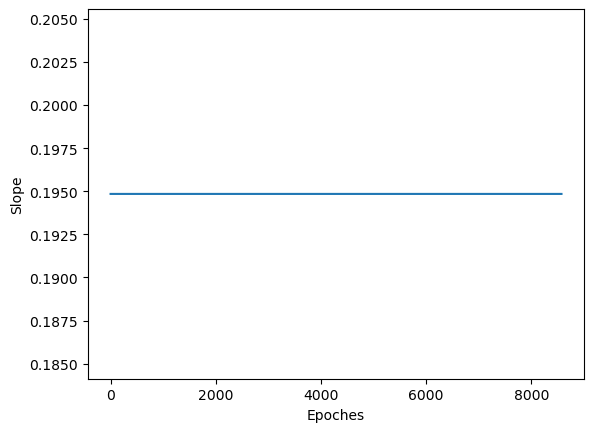

In [20]:
    xielv,sss=model2.sssss()
    xielv =np.array(xielv)
    x=np.arange(1,len(xielv)+1)
    plt.plot(x,xielv)
    plt.xlabel('Epoches')
    plt.ylabel('Slope')
    plt.show()

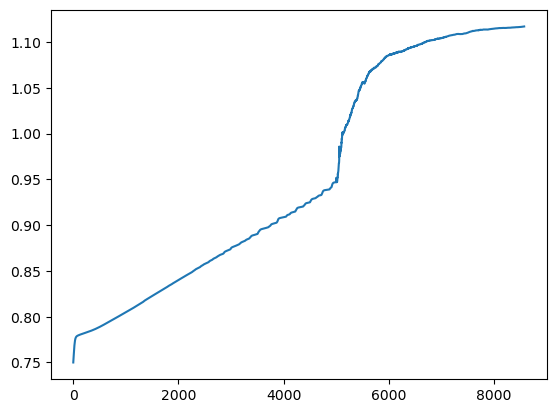

In [21]:
    xielv,sss=model2.sssss()
    xielv =np.array(sss)
    x=np.arange(1,len(sss)+1)
    plt.plot(x,xielv)
    plt.show()

In [22]:
    lb = np.array([-1.0, 0])
    ub = np.array([1.0, 1.0])

In [23]:
    t = data['tt'].flatten()[:,None]
    x = data['x'].flatten()[:,None]
    Exact = data['uu']
    
    X, T = np.meshgrid(x,t)
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_star = Exact.T.flatten()[:,None]
    u_pred,_ = model2.predict(X_star[:,0:1],X_star[:,1:2])

    erroru = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    erroru1 = np.linalg.norm(u_star-u_pred,1)/len(X_star)
    erroruinf = np.linalg.norm(u_star-u_pred,np.inf)
    
    print('randorm seed: %d' % (RandomSeed))
    print('Training error in pre-training interval:(%.2f,%.2f)' % (lb[1], ubp[1]) ) 
    print('Error2 u: %e' % (erroru))
    print('Error1 u: %e' % (erroru1))
    print('Errorf u: %e' % (erroruinf))

randorm seed: 9
Training error in pre-training interval:(0.00,1.00)
Error2 u: 6.535895e-04
Error1 u: 2.105796e-04
Errorf u: 6.414754e-03


No handles with labels found to put in legend.


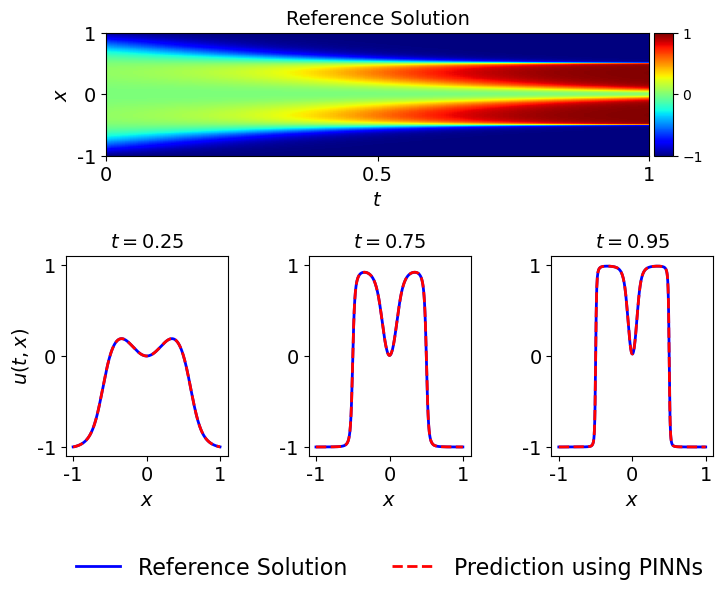

In [24]:
    U_preds=u_pred.reshape(201,512).T    
    H_pred=U_preds.T
    Exact_h=Exact    
    fig, ax = newfig(1.5, 0.9)
    ax.axis('off')
    
    ####### Row 0: h(t,x) ##################    
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])
    
    h = ax.imshow(Exact, interpolation='nearest', cmap='jet', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto',vmin=-1,vmax=1)
    
    ax.set_xticks([0,0.5,1])
    ax.set_xticklabels([0,0.5,1], fontsize=14)
    ax.set_yticks([-1,0,1])
    ax.set_yticklabels([-1,0,1], fontsize=14)
    
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3.5%", pad=0.05)
    cbar = fig.colorbar(h, cax=cax)  
    cbar.set_ticks([-1,0,1])
    cbar.ax.tick_params(labelsize=10)      
    
    a=50
    b=150
    c=190

    
    ax.set_xlabel('$t$', fontsize=14)
    ax.set_ylabel('$x$', fontsize=14)
    leg = ax.legend(frameon=False, loc = 'best')
#    plt.setp(leg.get_texts(), color='w')
    ax.set_title('Reference Solution', fontsize = 14)
    
    ####### Row 1: h(t,x) slices ##################    
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/1.8, bottom=0, left=0.1, right=0.9, wspace=0.5)
    
    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,Exact_h[:,a], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,H_pred[a,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$', fontsize=14)
    ax.set_ylabel('$u(t,x)$', fontsize=14)   
    ax.set_title('$t = %.2f$' % (t[a]), fontsize = 14)

    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_yticks([-1,0,1])
    ax.set_yticklabels([-1,0,1], fontsize=14)
    ax.set_xticks([-1,0,1])
    ax.set_xticklabels([-1,0,1], fontsize=14)
    
    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,Exact_h[:,b], 'b-', linewidth = 2, label = 'Reference Solution')       
    ax.plot(x,H_pred[b,:], 'r--', linewidth = 2, label = 'Prediction using PINNs')
    ax.set_xlabel('$x$', fontsize=14)

    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_yticks([-1,0,1])
    ax.set_yticklabels([-1,0,1], fontsize=14)
    ax.set_xticks([-1,0,1])
    ax.set_xticklabels([-1,0,1], fontsize=14)
    ax.set_title('$t = %.2f$' % (t[b]), fontsize = 14)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=5, frameon=False, fontsize=16)
    
    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,Exact_h[:,c], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,H_pred[c,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$', fontsize=14)

    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])   
    ax.set_yticks([-1,0,1])
    ax.set_yticklabels([-1,0,1], fontsize=14)
    ax.set_xticks([-1,0,1])
    ax.set_xticklabels([-1,0,1], fontsize=14)
    ax.set_title('$t = %.2f$' % (t[c]), fontsize = 14)

    plt.show() 

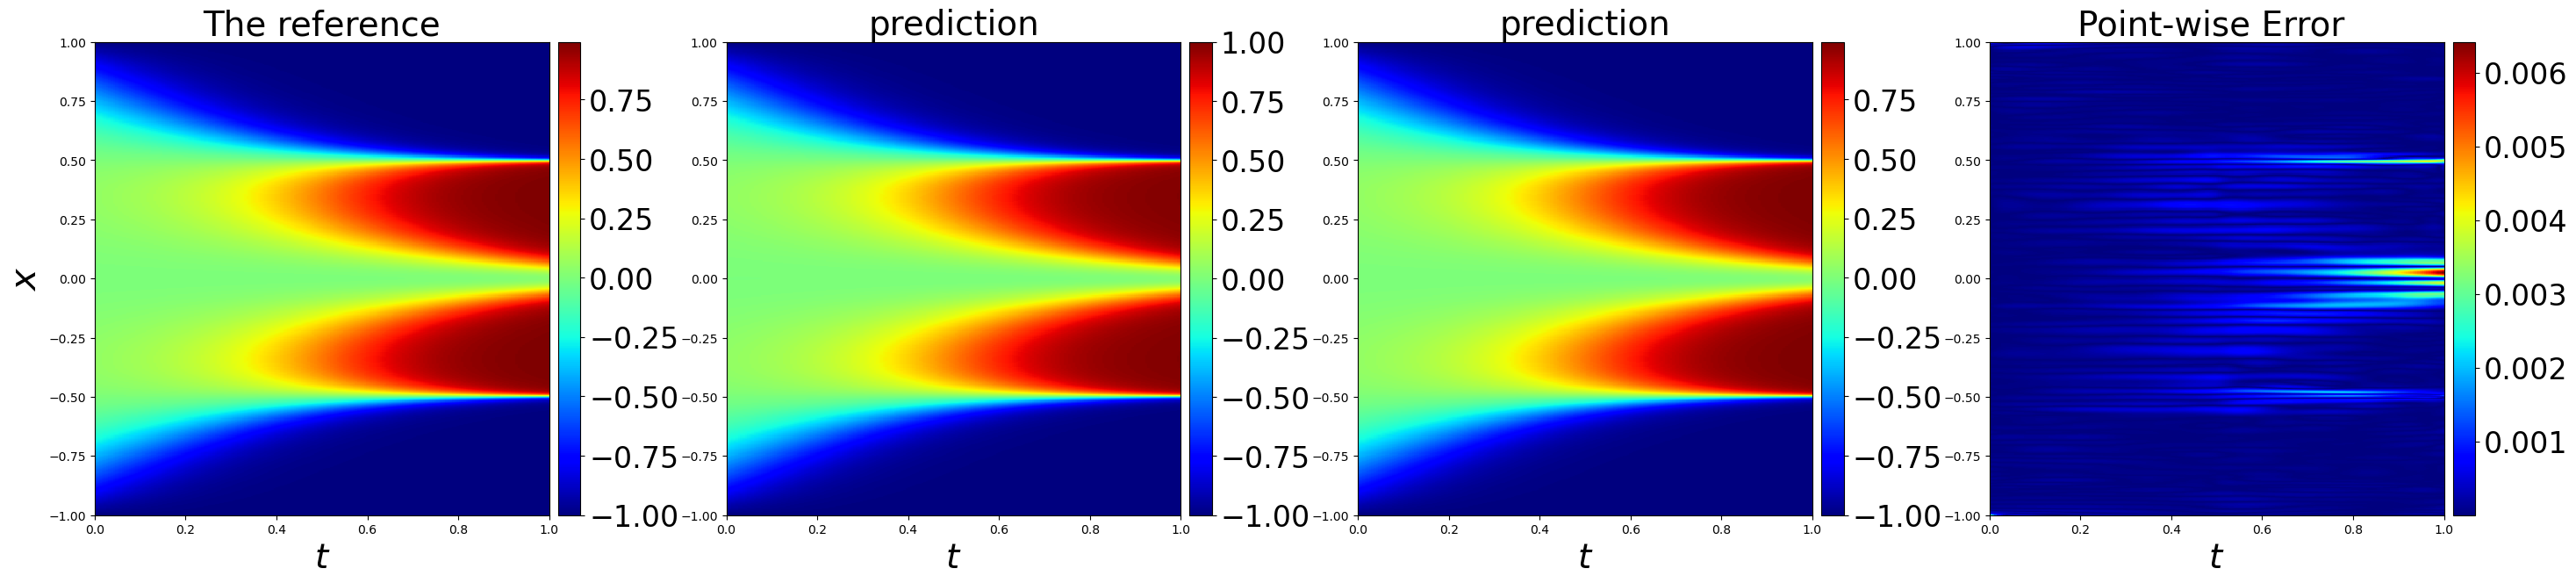

In [25]:
    fig, axs = plt.subplots(1, 4, figsize=(35, 7))
    fig.subplots_adjust(wspace=0.3)  # 调整子图之间的水平间距

    # 第一个子图
    ax1 = axs[2]    
    h = ax1.imshow(U_preds, interpolation='nearest', cmap='jet', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
    ax1.set_title(r'prediction', fontsize=28)
    ax1.set_xlabel('$t$', fontsize=28)
    #左边的色差图
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(h, cax=cax)  

    cbar.ax.tick_params(labelsize=24)   
    
    
    # 第一个子图
    ax1 = axs[1]    
    h = ax1.imshow(U_preds, interpolation='nearest', cmap='jet', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto',vmin=-1,vmax=1)
    ax1.set_title(r'prediction', fontsize=28)
    ax1.set_xlabel('$t$', fontsize=28)
    #左边的色差图
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(h, cax=cax)  

    cbar.ax.tick_params(labelsize=24)      
    
    
    
    ax2 = axs[0]    
    h = ax2.imshow(Exact, interpolation='nearest', cmap='jet', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
    ax2.set_title('The reference', fontsize=28)
    ax2.set_xlabel('$t$', fontsize=28)
    ax2.set_ylabel('$x$', fontsize=30)
    #左边的色差图
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(h, cax=cax)  

    cbar.ax.tick_params(labelsize=24)       
    
    ax3 = axs[3]    
    h = ax3.imshow(np.abs(Exact-U_preds), interpolation='nearest', cmap='jet', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
    ax3.set_title(r'Point-wise Error ', fontsize=28)
    ax3.set_xlabel('$t$', fontsize=28)
    #左边的色差图
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(h, cax=cax)  

    cbar.ax.tick_params(labelsize=24)     
    
    #plt.savefig('Waterasdes.jpg', dpi=500, bbox_inches='tight') # 解决图片不清晰，不完整的问题
    plt.savefig('0_15_exact_solution_and_point_wise_error_by_mmpinn_and_standard.pdf', bbox_inches='tight') 
    plt.show() 

In [26]:
a= model2.sess.run(model2.b)
a

1.1169011802855184

In [27]:
a= model2.sess.run(model2.a)
a

0.19484481613175275